# Business Problem:

## Background

Add Information Education/Grad rates in the Tri-State area

The Northeast includes Maine, New Hampshire, Vermont, Massachusetts, Rhode Island, Connecticut, New York, New Jersey, and Pennsylvania.

## Problem Statement

Predict which schools have high and which schools have low high school graduation rates. Identify which characteristics are the best indicator of high and low graduation rates so that school districts know where to focus resources when attempting to increase high school graduation rates.

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
# import xgboost as xgb
import catboost
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from catboost import Pool, sum_models
from catboost import CatBoostClassifier
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, balanced_accuracy_score
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,  OneHotEncoder, MinMaxScaler, StandardScaler 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, truncnorm, randint

# Data Exploration and Prep

## Data Load

In [2]:
#New York school and district data
df_school_NY = pd.read_csv('data/EducationDataPortal_schools_NY.csv')
df_district_NY = pd.read_csv('data/EducationDataPortal_districts_NY.csv')

In [3]:
#Pennsylvania school and district data 
df_school_PA = pd.read_csv('data/EducationDataPortal_schools_PA.csv')
df_district_PA = pd.read_csv('data/EducationDataPortal_districts_PA.csv')

In [4]:
#New Jersey school and district data
df_school_NJ = pd.read_csv('data/EducationDataPortal_schools_NJ.csv')
df_district_NJ = pd.read_csv('data/EducationDataPortal_districts_NJ.csv')

In [5]:
#Maine school and district data
df_school_ME = pd.read_csv('data/EducationDataPortal_schools_ME.csv')
df_district_ME = pd.read_csv('data/EducationDataPortal_districts_ME.csv')

In [6]:
#Massachusetts school and district data
df_school_MA = pd.read_csv('data/EducationDataPortal_schools_MA.csv')
df_district_MA = pd.read_csv('data/EducationDataPortal_districts_MA.csv')

In [7]:
#Rhode Island school and district data
df_school_RI = pd.read_csv('data/EducationDataPortal_schools_RI.csv')
df_district_RI = pd.read_csv('data/EducationDataPortal_districts_RI.csv')

In [8]:
#Vermont school and district data
df_school_VT = pd.read_csv('data/EducationDataPortal_schools_VT.csv')
df_district_VT = pd.read_csv('data/EducationDataPortal_districts_VT.csv')

In [9]:
#Connecticut school and district data
df_school_CT = pd.read_csv('data/EducationDataPortal_schools_CT.csv')
df_district_CT = pd.read_csv('data/EducationDataPortal_districts_CT.csv')

In [10]:
#Connecticut school and district data
df_school_NH = pd.read_csv('data/EducationDataPortal_schools_NH.csv')
df_district_NH = pd.read_csv('data/EducationDataPortal_districts_NH.csv')

## Functions

In [11]:
# Returns the percentage of values in a dataframe that are nulls
def percent_null_df (df,str_name):
    count_null = df.isnull().sum().sum()
    count_non_null = df.count().sum()
    return 'percent of nulls in '+ str_name +' is '+str(int((count_null/(count_null + count_non_null))*100))+'%'
    

## df_school

In [12]:
#Concatenate school info for all three states into one dataframe
df_school = pd.concat([df_school_NY, df_school_PA, df_school_NJ,
                       df_school_ME, df_school_MA,df_school_VT,
                       df_school_CT,df_school_RI,df_school_NH])

In [13]:
df_school['state_name'].value_counts(normalize=True, dropna=False)

Pennsylvania     0.262852
New Jersey       0.222289
Massachusetts    0.160974
Connecticut      0.117421
New York         0.087532
Maine            0.052775
New Hampshire    0.042015
Vermont          0.027156
Rhode Island     0.026985
Name: state_name, dtype: float64

In [14]:
df_school

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,2015,360000104498,JAMES A GREEN HIGH SCHOOL,New York,DOLGEVILLE CENTRAL SCHOOL DISTRICT,13329,"Rural, distant",High,Regular school,No,...,28.0,10.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
1,2015,360000204500,SAUQUOIT VALLEY HIGH SCHOOL,New York,SAUQUOIT VALLEY CENTRAL SCHOOL DISTRICT,13456,"Rural, fringe",High,Regular school,No,...,43.0,28.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0
2,2015,360000304543,EDWARDS-KNOX JUNIOR-SENIOR HIGH SCHOOL,New York,EDWARDS-KNOX CENTRAL SCHOOL DISTRICT,13652,"Rural, remote",High,Regular school,No,...,16.0,13.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
3,2015,360000404545,MOHONASEN SENIOR HIGH SCHOOL,New York,ROTTERDAM-MOHONASEN CENTRAL SCHOOL DISTRICT,12303,"Suburb, large",High,Regular school,No,...,107.0,41.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,606.0
4,2015,360000500282,BROADALBIN-PERTH HIGH SCHOOL,New York,BROADALBIN-PERTH CENTRAL SCHOOL DISTRICT,12025,"Rural, distant",High,Regular school,No,...,32.0,29.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,2015,330730000466,Winnisquam Regional Middle School,New Hampshire,Winnisquam Regional School District,3276,"Town, distant",Middle,Regular school,No,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488,2015,330730000467,Union Sanborn School,New Hampshire,Winnisquam Regional School District,3276,"Town, distant",Primary,Regular school,No,...,NaN,NaN,NaN,0.0,1.0,0.0,0.0,2.0,0.0,0.0
489,2015,330733000519,Coe-Brown Northwood Academy,New Hampshire,Coe Brown Academy School District,3261,"Rural, distant",High,Regular school,No,...,111.0,33.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,174.0
490,2015,330736000510,Pinkerton Academy,New Hampshire,Pinkerton Academy School District,3038,"Suburb, midsize",High,Regular school,No,...,699.0,1194.0,834.0,0.0,0.0,0.0,0.0,0.0,0.0,798.0


### Data Fields

In [15]:
df_school.head()

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,2015,360000104498,JAMES A GREEN HIGH SCHOOL,New York,DOLGEVILLE CENTRAL SCHOOL DISTRICT,13329,"Rural, distant",High,Regular school,No,...,28.0,10.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
1,2015,360000204500,SAUQUOIT VALLEY HIGH SCHOOL,New York,SAUQUOIT VALLEY CENTRAL SCHOOL DISTRICT,13456,"Rural, fringe",High,Regular school,No,...,43.0,28.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0
2,2015,360000304543,EDWARDS-KNOX JUNIOR-SENIOR HIGH SCHOOL,New York,EDWARDS-KNOX CENTRAL SCHOOL DISTRICT,13652,"Rural, remote",High,Regular school,No,...,16.0,13.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
3,2015,360000404545,MOHONASEN SENIOR HIGH SCHOOL,New York,ROTTERDAM-MOHONASEN CENTRAL SCHOOL DISTRICT,12303,"Suburb, large",High,Regular school,No,...,107.0,41.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,606.0
4,2015,360000500282,BROADALBIN-PERTH HIGH SCHOOL,New York,BROADALBIN-PERTH CENTRAL SCHOOL DISTRICT,12025,"Rural, distant",High,Regular school,No,...,32.0,29.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0


In [16]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11710 entries, 0 to 491
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             11710 non-null  int64  
 1   ncessch                          11710 non-null  int64  
 2   school_name                      11710 non-null  object 
 3   state_name                       11710 non-null  object 
 4   lea_name                         11710 non-null  object 
 5   zip_location                     11710 non-null  int64  
 6   urban_centric_locale             11607 non-null  object 
 7   school_level                     11710 non-null  object 
 8   school_type                      11710 non-null  object 
 9   charter                          11710 non-null  object 
 10  enrollment                       11531 non-null  object 
 11  read_test_num_valid              10375 non-null  float64
 12  read_test_pct_prof_l

In [17]:
df_school.shape

(11710, 64)

In [18]:
df_school_PA.shape

(3078, 64)

In [19]:
3078*.33

1015.74

In [20]:
df_school_PA['grad_rate_midpt'].value_counts(normalize=True,dropna=False)

NaN                0.778428
92                 0.045159
97                 0.044185
87                 0.022092
95                 0.019168
96                 0.008447
82                 0.007472
84                 0.006173
93                 0.005848
91                 0.005198
99                 0.005198
94                 0.005198
90                 0.004224
98                 0.003899
77                 0.003249
75                 0.002274
85                 0.001949
71                 0.001949
88                 0.001949
67                 0.001624
89                 0.001624
86                 0.001624
57                 0.001300
Suppressed data    0.001300
24                 0.001300
52                 0.001300
62                 0.001300
72                 0.001300
2                  0.001300
44                 0.001300
69                 0.000975
66                 0.000650
56                 0.000650
83                 0.000650
42                 0.000650
68                 0

In [21]:
df_school_NJ.shape

(2603, 64)

In [22]:
2603*(1-.84)

416.4800000000001

In [23]:
df_school_NJ['grad_rate_midpt'].value_counts(normalize=True,dropna=False)

NaN     0.839800
97.0    0.036881
92.0    0.019209
95.0    0.013446
87.0    0.012678
96.0    0.009220
98.0    0.008452
94.0    0.006147
91.0    0.005763
90.0    0.005378
82.0    0.003458
99.0    0.003458
93.0    0.003458
77.0    0.003073
72.0    0.003073
89.0    0.002305
84.0    0.002305
85.0    0.001921
75.0    0.001921
24.0    0.001153
78.0    0.001153
88.0    0.001153
83.0    0.001153
79.0    0.001153
86.0    0.001153
74.0    0.001153
81.0    0.001153
67.0    0.000768
71.0    0.000768
69.0    0.000768
80.0    0.000768
64.0    0.000768
62.0    0.000384
60.0    0.000384
2.0     0.000384
61.0    0.000384
54.0    0.000384
66.0    0.000384
51.0    0.000384
70.0    0.000384
76.0    0.000384
65.0    0.000384
41.0    0.000384
27.0    0.000384
73.0    0.000384
Name: grad_rate_midpt, dtype: float64

#### Data Field Cleanup

In [24]:
column_names = list(df_school.columns)

In [25]:
categorical = ['year','ncessch','school_name','state_name','lea_name','zip_location',
               'urban_centric_locale','school_level','school_type','charter',
               'corpinstances_preschool']


In [26]:
#use for loop if statement to create numerical list is more intuitive
for ele in categorical:
    try:
        column_names.remove(ele)
    except ValueError:
        pass

In [27]:
numerical = column_names

In [28]:
column_names = list(df_school.columns)

In [29]:
for c in column_names:
    df_school[c].replace('Suppressed data', np.NaN,inplace =True)

In [30]:
for c in column_names:
    df_school[c].replace('Not applicable', np.NaN,inplace =True)

In [31]:
for c in column_names:
    df_school[c].replace('Missing/not reported', np.NaN,inplace =True)

### Columns to drop

In [32]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11710 entries, 0 to 491
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             11710 non-null  int64  
 1   ncessch                          11710 non-null  int64  
 2   school_name                      11710 non-null  object 
 3   state_name                       11710 non-null  object 
 4   lea_name                         11710 non-null  object 
 5   zip_location                     11710 non-null  int64  
 6   urban_centric_locale             11607 non-null  object 
 7   school_level                     11531 non-null  object 
 8   school_type                      11710 non-null  object 
 9   charter                          11392 non-null  object 
 10  enrollment                       11465 non-null  object 
 11  read_test_num_valid              10375 non-null  float64
 12  read_test_pct_prof_l

In [33]:
df_school['corpinstances_preschool'].value_counts(normalize=True, dropna=False)

-1.0    0.926815
 NaN    0.072673
 0.0    0.000427
 1.0    0.000085
Name: corpinstances_preschool, dtype: float64

In [34]:
df_school['students_corporal_punish'].value_counts(normalize=True, dropna=False)

NaN    0.999488
0      0.000512
Name: students_corporal_punish, dtype: float64

- Drop year as this is the same for all rows
- Drop corpinstances_preschool this column is mostly -1 which is not interpretable

In [35]:
df_school = df_school.drop(['year','corpinstances_preschool','students_corporal_punish'], axis=1)

### school_type

In [36]:
df_school['school_type'].value_counts(normalize=True, dropna=False)

Regular school              0.930231
Other/alternative school    0.024167
Vocational school           0.022801
Special education school    0.022801
Name: school_type, dtype: float64

In [37]:
df_school_regular = df_school.loc[df_school['school_type'] == 'Regular school']
df_school_regular

,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,enrollment,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,360000104498,JAMES A GREEN HIGH SCHOOL,New York,DOLGEVILLE CENTRAL SCHOOL DISTRICT,13329,"Rural, distant",High,Regular school,No,288,...,28.0,10.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
1,360000204500,SAUQUOIT VALLEY HIGH SCHOOL,New York,SAUQUOIT VALLEY CENTRAL SCHOOL DISTRICT,13456,"Rural, fringe",High,Regular school,No,309,...,43.0,28.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0
2,360000304543,EDWARDS-KNOX JUNIOR-SENIOR HIGH SCHOOL,New York,EDWARDS-KNOX CENTRAL SCHOOL DISTRICT,13652,"Rural, remote",High,Regular school,No,270,...,16.0,13.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
3,360000404545,MOHONASEN SENIOR HIGH SCHOOL,New York,ROTTERDAM-MOHONASEN CENTRAL SCHOOL DISTRICT,12303,"Suburb, large",High,Regular school,No,946,...,107.0,41.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,606.0
4,360000500282,BROADALBIN-PERTH HIGH SCHOOL,New York,BROADALBIN-PERTH CENTRAL SCHOOL DISTRICT,12025,"Rural, distant",High,Regular school,No,551,...,32.0,29.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,330730000466,Winnisquam Regional Middle School,New Hampshire,Winnisquam Regional School District,3276,"Town, distant",Middle,Regular school,No,353,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488,330730000467,Union Sanborn School,New Hampshire,Winnisquam Regional School District,3276,"Town, distant",Primary,Regular school,No,243,...,NaN,NaN,NaN,0.0,1.0,0.0,0.0,2.0,0.0,0.0
489,330733000519,Coe-Brown Northwood Academy,New Hampshire,Coe Brown Academy School District,3261,"Rural, distant",High,Regular school,No,701,...,111.0,33.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,174.0
490,330736000510,Pinkerton Academy,New Hampshire,Pinkerton Academy School District,3038,"Suburb, midsize",High,Regular school,No,3111,...,699.0,1194.0,834.0,0.0,0.0,0.0,0.0,0.0,0.0,798.0


In [38]:
df_school_alternative = df_school.loc[df_school['school_type'] == 'Other/alternative school']
df_school_alternative

,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,enrollment,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
13,360001706539,ALLEGANY CO SHERIFF C/O TREASURER,New York,GENESEE VALLEY CENTRAL SCHOOL DISTRICT,14813,"Rural, distant",High,Other/alternative school,No,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,360001806526,CHAUTAUQUA COUNTY JAIL,New York,CHAUTAUQUA LAKE CENTRAL SCHOOL DISTRICT,14757,"Rural, distant",High,Other/alternative school,No,17,...,NaN,NaN,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,360005304411,JOHN V LINDSAY WILDCAT ACADEMY CHARTER SCHOOL,New York,JOHN V LINDSAY WILDCAT ACADEMY CHARTER SCHOOL,10004,"City, large",High,Other/alternative school,Yes,473,...,17.0,NaN,176.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
21,360007600624,LOWER EAST SIDE PREPARATORY HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 1,10002,"City, large",High,Other/alternative school,No,487,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,30.0
23,360007603352,CASCADES HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 1,10002,"City, large",High,Other/alternative school,No,220,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,440000900413,DCYF Alternative Ed. Program,Rhode Island,DCYF,2920,"Suburb, large",High,Other/alternative school,No,65,...,11.0,NaN,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,440015000286,The R.Y.S.E School,Rhode Island,Chariho,2894,"Rural, fringe",Other,Other/alternative school,No,55,...,14.0,NaN,9.0,0.0,68.0,0.0,0.0,11.0,0.0,0.0
204,440090000055,Academy for Career Exploration,Rhode Island,Providence,2907,"City, midsize",High,Other/alternative school,Yes,201,...,63.0,75.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
210,440090000157,Times2 Academy,Rhode Island,Providence,2908,"City, midsize",Other,Other/alternative school,Yes,675,...,62.0,54.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0


In [39]:
df_school_vocational = df_school.loc[df_school['school_type'] == 'Vocational school']
df_school_vocational.head(10)

,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,enrollment,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
41,360007701911,ART AND DESIGN HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 2,10019,"City, large",High,Vocational school,No,1448,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,190.0
42,360007701934,CHELSEA CAREER AND TECHNICAL EDUCATION HIGH SC...,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 2,10013,"City, large",High,Vocational school,No,439,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,60.0
43,360007701949,HIGH SCHOOL OF FASHION INDUSTRIES (THE),New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 2,10011,"City, large",High,Vocational school,No,1807,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,463.0
52,360007704519,HIGH SCHOOL OF GRAPHIC COMMUNICATION ARTS,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 2,10019,"City, large",High,Vocational school,No,139,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,14.0
120,360008401909,ALFRED E SMITH CAREER AND TECHNICAL HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 7,10451,"City, large",High,Vocational school,No,417,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,32.0
219,360009101928,BROOKLYN TECHNICAL HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT #13,11217,"City, large",High,Vocational school,No,5534,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,1708.0
220,360009101955,GEORGE WESTINGHOUSE CAREER & TECHNICAL ED HIGH...,New York,NEW YORK CITY GEOGRAPHIC DISTRICT #13,11201,"City, large",High,Vocational school,No,613,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,41.0
247,360009501937,CLARA BARTON HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT #17,11225,"City, large",High,Vocational school,No,1352,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,227.0
281,360009801915,AVIATION CAREER AND TECHNICAL HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT #24,11101,"City, large",High,Vocational school,No,2147,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,338.0
284,360009802860,QUEENS VOCATIONAL AND TECHNICAL HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT #24,11101,"City, large",High,Vocational school,No,1581,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,232.0


In [40]:
df_school_special = df_school.loc[df_school['school_type'] == 'Special education school']
df_school_special.head(10)

,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,enrollment,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
395,360013500806,PS 373 BROOKLYN TRANSITION CENTER,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,11206,"City, large",High,Special education school,No,383,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0
396,360013501923,PS 721 STEVEN MCSWEENEY SCHOOL,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,10461,"City, large",High,Special education school,No,561,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,18.0
397,360013502026,PS 721 MANHATTAN OCCUPATIONAL TRAINING CENTER,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,10014,"City, large",High,Special education school,No,176,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,2.0
398,360013502827,PS 371 LILLIAN L RASHKIS,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,11232,"City, large",High,Special education school,No,267,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,6.0
399,360013502844,PS 811,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,10459,"City, large",High,Special education school,No,639,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,2.0
400,360013502859,JOHN F KENNEDY JR SCHOOL,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,11373,"City, large",High,Special education school,No,486,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,2.0
401,360013502870,MANHATTAN SCHOOL FOR CAREER DEVELOPMENT,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,10003,"City, large",High,Special education school,No,188,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,4.0
402,360013504319,PS 753 SCHOOL FOR CAREER DEVELOPMENT,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,11238,"City, large",High,Special education school,No,213,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0
403,360013504481,QUEENS TRANSITION CENTER,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,11436,"City, large",High,Special education school,No,385,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,4.0
404,360013504522,JM RAPPORT SCHOOL FOR CAREER DEVELOPMENT,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,10455,"City, large",High,Special education school,No,509,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,2.0


In [41]:
#Proportion of nulls regular school type
percent_null_df(df_school_regular,'df_school_regular')

'percent of nulls in df_school_regular is 16%'

In [42]:
#Proportion of nulls vocational school type
percent_null_df(df_school_vocational,'df_school_vocational')

'percent of nulls in df_school_vocational is 35%'

In [43]:
#Proportion of nulls alternative school type
percent_null_df(df_school_alternative,'df_school_alternative')

'percent of nulls in df_school_alternative is 41%'

In [44]:
#Proportion of nulls special education school type
percent_null_df(df_school_special,'df_school_special')

'percent of nulls in df_school_special is 49%'

Our Other/alternative school in the school_type field includes jails and detention centers. Many of these correctional facilities have a lot of NaN values in other data fields. We will remove all rows with alternative schools since there seems to be many missing values for these types of schools and because students in these types of schools are experiencing circumstances and educational experiences very different from the majority of students.

We will also remove vocational and special education school types as these school types are a small percentage of the data and have high proportion of nulls

In [45]:
df_school.shape[0]

11710

In [46]:
df_school = df_school.loc[df_school['school_type'] == 'Regular school']
df_school.shape[0]

10893

In [47]:
# # Set it equal to regular instead of taking out each of the three
# df_school.drop(df_school[df_school['school_type'] == 'Other/alternative school' ].index, inplace = True)
# df_school.shape[0]

In [48]:
# df_school.drop(df_school[df_school['school_type'] == 'Vocational school' ].index, inplace = True)
# df_school.shape[0]

In [49]:
# df_school.drop(df_school[df_school['school_type'] == 'Special education school' ].index, inplace = True)
# df_school.shape[0]

### Graduation Rate - format the target

- The graduation rates are numerical values separated into three columns.
 - grad_rate_high
 - grad_rate_midpt 
 - grad_rate_low
 
- Looking at the data documentation from EDFacts https://www2.ed.gov/about/inits/ed/edfacts/index.htmlThe we see that the reason for multiple columns is that some schools choose to report graduation rates in a range so that student privacy is protected. The range creates a low and a high column with the midpoint being the value in the middle of the low and high values.
- We will use grad_rate_midpt to measure graduation rates as this is the most balanced.


- The federal government defines graduation rates as low when less than 2/3 of a cohort receive a diploma in 4 years or less.  
- We will classify high schools with midpoint graduation rates 66 and below as low and high schools with midpoint graduation rates of 67 and above as high.


In [50]:
#Let's see a few examples of the grad rate reporting range before we drop the high and low cols
grad_rate_cols = ['school_name','cohort_num','grad_rate_high','grad_rate_midpt',
                  'grad_rate_low']

In [51]:
df_school[grad_rate_cols].head(10)

,school_name,cohort_num,grad_rate_high,grad_rate_midpt,grad_rate_low
0,JAMES A GREEN HIGH SCHOOL,70.0,89,87,85
1,SAUQUOIT VALLEY HIGH SCHOOL,86.0,94,92,90
2,EDWARDS-KNOX JUNIOR-SENIOR HIGH SCHOOL,51.0,79,74,70
3,MOHONASEN SENIOR HIGH SCHOOL,227.0,85,85,85
4,BROADALBIN-PERTH HIGH SCHOOL,132.0,94,92,90
5,JASPER-TROUPSBURG JUNIOR-SENIOR HIGH SCHOOL,49.0,79,74,70
6,BELLPORT SENIOR HIGH SCHOOL,349.0,84,84,84
7,SARANAC HIGH SCHOOL,131.0,89,87,85
8,WAYLAND-COHOCTON HIGH SCHOOL,103.0,94,92,90
9,ONEIDA SENIOR HIGH SCHOOL,171.0,84,82,80


In [52]:
df_school = df_school.drop(['grad_rate_high','grad_rate_low'], axis=1)

In [53]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10893 entries, 0 to 491
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          10893 non-null  int64  
 1   school_name                      10893 non-null  object 
 2   state_name                       10893 non-null  object 
 3   lea_name                         10893 non-null  object 
 4   zip_location                     10893 non-null  int64  
 5   urban_centric_locale             10879 non-null  object 
 6   school_level                     10780 non-null  object 
 7   school_type                      10893 non-null  object 
 8   charter                          10591 non-null  object 
 9   enrollment                       10768 non-null  object 
 10  read_test_num_valid              10097 non-null  float64
 11  read_test_pct_prof_low           10054 non-null  object 
 12  read_test_pct_prof_h

In [54]:
df_school['grad_rate_midpt'].value_counts(normalize=True,dropna=False)

NaN     0.741761
97      0.029560
92      0.027173
87      0.017167
97.0    0.013219
          ...   
66.0    0.000092
36      0.000092
35      0.000092
70.0    0.000092
48      0.000092
Name: grad_rate_midpt, Length: 125, dtype: float64

In [55]:
df_school.update(df_school[['grad_rate_midpt']].fillna(0))

In [56]:
df_school.shape

(10893, 59)

In [57]:
df_school['grad_rate_midpt'].value_counts(normalize=True,dropna=False)

0       0.741761
97      0.029560
92      0.027173
87      0.017167
97.0    0.013219
          ...   
66.0    0.000092
36      0.000092
35      0.000092
70.0    0.000092
48      0.000092
Name: grad_rate_midpt, Length: 125, dtype: float64

In [58]:
5851*(1-.7)

1755.3000000000002

In [59]:
df_school = df_school[df_school.grad_rate_midpt != 0]

In [60]:
df_school.shape[0]

2813

In [61]:
# convert grad rate columns to numeric
df_school[['grad_rate_midpt']] = df_school[['grad_rate_midpt']].astype(str).astype(float).astype(int)


In [62]:
# Let's take a look at the summary statistics for the grad_rate_midpt column

print(df_school['grad_rate_midpt'].describe())


count    2813.000000
mean       84.835763
std        16.951988
min         2.000000
25%        82.000000
50%        92.000000
75%        96.000000
max        99.000000
Name: grad_rate_midpt, dtype: float64


In [63]:
 print('grad_rate_midpt', '\n', df_school['grad_rate_midpt'].value_counts(normalize=True).head(), '\n\n')

grad_rate_midpt 
 97    0.165659
92    0.143619
87    0.094205
95    0.069677
82    0.044437
Name: grad_rate_midpt, dtype: float64 




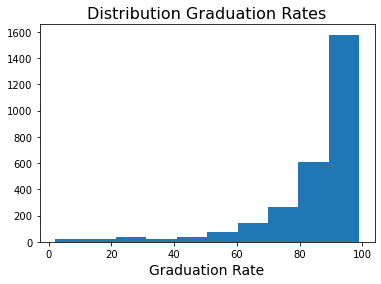

In [64]:
# Plot of the target status group

plt.hist(df_school['grad_rate_midpt'])
plt.xlabel('Graduation Rate', fontsize=14)
plt.title("Distribution Graduation Rates", fontsize=16)
plt.show()


It looks like there is a strong skew towards higher performing high schools. Lets go ahead and bin our values and then take a look at the distribution again.

#### Bin the target

As stated above based on how the federal government defines low graduation rates we will be dividing graduation rates into two bins:
- Low: 66 and below
- High: 67 and above

In [65]:
#Based on the federal government's definition we will define the bin ranges.
tsh_bins = [-1,0,20,350000]
grad_rate_bins = [0,66,100]

In [66]:
# now lets convert the grad_rate_midpt column to binned categories
# note that when binning these, the default setting is that the values on the right are included in the bin

df_school['grad_rate_midpt'] = pd.cut(df_school['grad_rate_midpt'], grad_rate_bins)

In [67]:
# and we will also take a look at the distribution across bins 
print(df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False))

(66, 100]    0.89513
(0, 66]      0.10487
Name: grad_rate_midpt, dtype: float64


In [68]:
# We need to address this class imbalance


#### Encode the target

In [69]:
df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False)

(66, 100]    0.89513
(0, 66]      0.10487
Name: grad_rate_midpt, dtype: float64

In [70]:
 df_school['grad_rate_midpt'] = df_school['grad_rate_midpt'].astype(str)

In [71]:
df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False)

(66, 100]    0.89513
(0, 66]      0.10487
Name: grad_rate_midpt, dtype: float64

In [72]:
 df_school['grad_rate_midpt'] = df_school['grad_rate_midpt'].replace('(0, 66]', 0)

In [73]:
 df_school['grad_rate_midpt'] = df_school['grad_rate_midpt'].replace('(66, 100]', 1)

### subject enrollment - drop all enrl columns

In [74]:
#Let's look at how many nulls we are dealing with now
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 4%'

In [75]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2813 entries, 0 to 491
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          2813 non-null   int64  
 1   school_name                      2813 non-null   object 
 2   state_name                       2813 non-null   object 
 3   lea_name                         2813 non-null   object 
 4   zip_location                     2813 non-null   int64  
 5   urban_centric_locale             2813 non-null   object 
 6   school_level                     2813 non-null   object 
 7   school_type                      2813 non-null   object 
 8   charter                          2753 non-null   object 
 9   enrollment                       2811 non-null   object 
 10  read_test_num_valid              2807 non-null   float64
 11  read_test_pct_prof_low           2792 non-null   object 
 12  read_test_pct_prof_hi

The class subject enrollment columns stand out as having the most null values let's drop those columns.

In [76]:
df_school = df_school.drop(['enrl_biology', 'enrl_chemistry','enrl_advanced_math',
                            'enrl_calculus','enrl_algebra2','enrl_physics',
                            'enrl_geometry'], axis=1)

In [77]:
#How do our nulls look
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 2%'

### Encode Charter

In [78]:
df_school['charter'].value_counts(normalize=True, dropna=False)

No     0.91006
Yes    0.06861
NaN    0.02133
Name: charter, dtype: float64

In [79]:
 df_school['charter'] = df_school['charter'].replace('No', 0)

In [80]:
 df_school['charter'] = df_school['charter'].replace('Yes', 1)

In [81]:
df_school['charter'].value_counts(normalize=True, dropna=False)

0.0    0.91006
1.0    0.06861
NaN    0.02133
Name: charter, dtype: float64

### Reading and Math Tests

In [82]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2813 entries, 0 to 491
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          2813 non-null   int64  
 1   school_name                      2813 non-null   object 
 2   state_name                       2813 non-null   object 
 3   lea_name                         2813 non-null   object 
 4   zip_location                     2813 non-null   int64  
 5   urban_centric_locale             2813 non-null   object 
 6   school_level                     2813 non-null   object 
 7   school_type                      2813 non-null   object 
 8   charter                          2753 non-null   float64
 9   enrollment                       2811 non-null   object 
 10  read_test_num_valid              2807 non-null   float64
 11  read_test_pct_prof_low           2792 non-null   object 
 12  read_test_pct_prof_hi

In [83]:
read_test = ['school_name', 'read_test_num_valid', 'read_test_pct_prof_low', 
             'read_test_pct_prof_high', 'read_test_pct_prof_midpt']

In [84]:
df_school[read_test].head(20)

,school_name,read_test_num_valid,read_test_pct_prof_low,read_test_pct_prof_high,read_test_pct_prof_midpt
0,JAMES A GREEN HIGH SCHOOL,58.0,90,100,95
1,SAUQUOIT VALLEY HIGH SCHOOL,71.0,95,100,97.5
2,EDWARDS-KNOX JUNIOR-SENIOR HIGH SCHOOL,130.0,45,49,47
3,MOHONASEN SENIOR HIGH SCHOOL,243.0,94,94,94
4,BROADALBIN-PERTH HIGH SCHOOL,146.0,90,94,92
5,JASPER-TROUPSBURG JUNIOR-SENIOR HIGH SCHOOL,103.0,45,49,47
6,BELLPORT SENIOR HIGH SCHOOL,287.0,89,89,89
7,SARANAC HIGH SCHOOL,102.0,95,100,97.5
8,WAYLAND-COHOCTON HIGH SCHOOL,83.0,95,100,97.5
9,ONEIDA SENIOR HIGH SCHOOL,174.0,90,94,92


In [85]:
math_test = ['school_name', 'math_test_num_valid' , 'math_test_pct_prof_low', 
             'math_test_pct_prof_high', 'math_test_pct_prof_midpt']

In [86]:
df_school[math_test].head(20)

,school_name,math_test_num_valid,math_test_pct_prof_low,math_test_pct_prof_high,math_test_pct_prof_midpt
0,JAMES A GREEN HIGH SCHOOL,58.0,80,89,84.5
1,SAUQUOIT VALLEY HIGH SCHOOL,73.0,95,100,97.5
2,EDWARDS-KNOX JUNIOR-SENIOR HIGH SCHOOL,127.0,50,54,52
3,MOHONASEN SENIOR HIGH SCHOOL,244.0,96,96,96
4,BROADALBIN-PERTH HIGH SCHOOL,147.0,90,94,92
5,JASPER-TROUPSBURG JUNIOR-SENIOR HIGH SCHOOL,99.0,40,44,42
6,BELLPORT SENIOR HIGH SCHOOL,296.0,89,89,89
7,SARANAC HIGH SCHOOL,102.0,95,100,97.5
8,WAYLAND-COHOCTON HIGH SCHOOL,84.0,95,100,97.5
9,ONEIDA SENIOR HIGH SCHOOL,175.0,90,94,92


The read_test_num_valid column and the math_test_num_valid column desribe the Number of students who completed a reading, and math assessment and for whom a proficiency level was assigned

The low, high, and midpt columns describe the low, high, and midpoint of the range used to report the share of students scoring proficient on a reading or language arts assessment (0–100 scale)



In [87]:
# The midpoint column is the most balanced measure so we will drop the others
df_school = df_school.drop(['math_test_pct_prof_low','math_test_pct_prof_high',
                           'read_test_pct_prof_low','read_test_pct_prof_high'], axis=1)

### Numeric Columns - nulls

Let's take a look at our columns and check back in on the proportion of nulls. If our proportion is small we will fill the NaNs in the remaining numerical columns with medians.

In [88]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2813 entries, 0 to 491
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          2813 non-null   int64  
 1   school_name                      2813 non-null   object 
 2   state_name                       2813 non-null   object 
 3   lea_name                         2813 non-null   object 
 4   zip_location                     2813 non-null   int64  
 5   urban_centric_locale             2813 non-null   object 
 6   school_level                     2813 non-null   object 
 7   school_type                      2813 non-null   object 
 8   charter                          2753 non-null   float64
 9   enrollment                       2811 non-null   object 
 10  read_test_num_valid              2807 non-null   float64
 11  read_test_pct_prof_midpt         2792 non-null   object 
 12  math_test_num_valid  

In [89]:
#How do our nulls look?
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 2%'

In [90]:
column_names = list(df_school.columns)

In [91]:
# We've dropped some of our numerical columns let's update our numerical list
numerical = set(column_names) - set(categorical)
numerical = list(numerical)
numerical

['allegations_harass_sex',
 'instances_mech_restraint',
 'students_arrested',
 'students_report_harass_race',
 'students_mech_restraint',
 'suspensions_instances',
 'students_disc_harass_sex',
 'grad_rate_midpt',
 'corpinstances',
 'instances_phys_restraint',
 'students_report_harass_sex',
 'expulsions_with_ed_serv',
 'math_test_pct_prof_midpt',
 'students_phys_restraint',
 'students_susp_out_sch_multiple',
 'students_susp_out_sch_single',
 'expulsions_zero_tolerance',
 'cohort_num',
 'students_susp_in_sch',
 'transfers_alt_sch_disc',
 'allegations_harass_race',
 'allegations_harass_disability',
 'read_test_pct_prof_midpt',
 'days_suspended',
 'instances_seclusion',
 'enrollment',
 'students_SAT_ACT',
 'students_disc_harass_dis',
 'allegations_harass_orientation',
 'math_test_num_valid',
 'students_report_harass_dis',
 'allegations_harass_religion',
 'students_disc_harass_race',
 'expulsions_no_ed_serv',
 'students_seclusion',
 'students_referred_law_enforce',
 'salaries_teachers',
 'r

In [92]:
numerical.remove('grad_rate_midpt')

In [93]:
nan_values = df_school.isna()
nan_columns = nan_values.any()
columns_with_nan = df_school.columns[nan_columns].tolist()
print(columns_with_nan)

['charter', 'enrollment', 'read_test_num_valid', 'read_test_pct_prof_midpt', 'math_test_num_valid', 'math_test_pct_prof_midpt', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple', 'expulsions_no_ed_serv', 'expulsions_with_ed_serv', 'expulsions_zero_tolerance', 'students_arrested', 'students_referred_law_enforce', 'transfers_alt_sch_disc', 'days_suspended', 'suspensions_instances_preschool', 'suspensions_instances', 'corpinstances', 'salaries_teachers', 'allegations_harass_sex', 'allegations_harass_race', 'allegations_harass_disability', 'allegations_harass_orientation', 'allegations_harass_religion', 'students_disc_harass_dis', 'students_disc_harass_race', 'students_disc_harass_sex', 'students_report_harass_dis', 'students_report_harass_race', 'students_report_harass_sex', 'instances_mech_restraint', 'instances_phys_restraint', 'instances_seclusion', 'students_mech_restraint', 'students_phys_restraint', 'students_seclusion', 'students_SAT_ACT']


In [94]:
#Replace NaNs with median for each column
df_school[numerical] = df_school[numerical].fillna(df_school[numerical].median())

In [95]:
nan_values = df_school.isna()
nan_columns = nan_values.any()
columns_with_nan = df_school.columns[nan_columns].tolist()
print(columns_with_nan)

['charter']


In [96]:
df_school[numerical] = df_school[numerical].astype(str).astype(float).astype(int)

In [97]:
#How do our nulls look?
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 0%'

## df_district

In [98]:
#Concatenate district info for all three states into one dataframe
df_district = pd.concat([df_district_NY, df_district_PA, df_district_NJ,
                         df_district_ME, df_district_MA, df_district_VT,
                         df_district_CT,df_district_RI, df_district_NH])

In [99]:
df_district['state_name'].value_counts(normalize=True, dropna=False)

New York         0.248913
Pennsylvania     0.193330
New Jersey       0.168439
Massachusetts    0.098840
Vermont          0.087724
New Hampshire    0.072499
Maine            0.064766
Connecticut      0.050024
Rhode Island     0.015466
Name: state_name, dtype: float64

### Data Fields

In [100]:
df_district.head()

,year,leaid,lea_name,state_name,state_leaid,city_location,urban_centric_locale,agency_type,enrollment,english_language_learners,...,outlay_capital_instruc_equip,outlay_capital_other_equip,outlay_capital_nonspec_equip,salaries_total,salaries_instruction,benefits_employee_total,cohort_num,grad_rate_high,grad_rate_low,grad_rate_midpt
0,2015,3600001,DOLGEVILLE CENTRAL SCHOOL DISTRICT,New York,211003040000,DOLGEVILLE,"Rural, distant",Regular local school district,928,Missing/not reported,...,52000,498000,0,9357000,6683000,5053000,76.0,84,80,82
1,2015,3600002,SAUQUOIT VALLEY CENTRAL SCHOOL DISTRICT,New York,411603040000,SAUQUOIT,"Rural, fringe",Regular local school district,1055,4,...,0,369000,0,10433000,7323000,5564000,87.0,94,90,92
2,2015,3600003,EDWARDS-KNOX CENTRAL SCHOOL DISTRICT,New York,513102040000,HERMON,"Rural, remote",Regular local school district,599,Missing/not reported,...,1000,280000,0,6310000,4101000,4012000,52.0,79,70,74
3,2015,3600004,ROTTERDAM-MOHONASEN CENTRAL SCHOOL DISTRICT,New York,530515060000,SCHENECTADY,"Suburb, large",Regular local school district,2812,28,...,16000,648000,0,26195000,17815000,11884000,235.0,83,83,83
4,2015,3600005,BROADALBIN-PERTH CENTRAL SCHOOL DISTRICT,New York,171102040000,BROADALBIN,"Rural, distant",Regular local school district,1836,3,...,0,602000,0,17090000,12135000,8621000,133.0,94,90,92


In [101]:
df_district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4138 entries, 0 to 299
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             4138 non-null   int64  
 1   leaid                            4138 non-null   int64  
 2   lea_name                         4138 non-null   object 
 3   state_name                       4138 non-null   object 
 4   state_leaid                      3867 non-null   object 
 5   city_location                    4138 non-null   object 
 6   urban_centric_locale             3867 non-null   object 
 7   agency_type                      4138 non-null   object 
 8   enrollment                       3927 non-null   object 
 9   english_language_learners        3664 non-null   object 
 10  est_population_total             2505 non-null   float64
 11  est_population_5_17_poverty      2505 non-null   float64
 12  est_population_5_17_p

In [102]:
#What proportion of our data frame is nulls?
percent_null_df(df_district,'df_district')

'percent of nulls in df_district is 10%'

Not bad. Let's deal with that 4%

#### Data Field Cleanup

In [103]:
column_names = list(df_district.columns)

In [104]:
categorical = ['year','leaid','leaname','state_name','state_leaid','city_location',
               'urban_centric_locale','agency_type']


In [105]:
for ele in categorical:
    try:
        column_names.remove(ele)
    except ValueError:
        pass

In [106]:
numerical = column_names

In [107]:
column_names = list(df_district.columns)

In [108]:
for c in column_names:
    df_district[c].replace('Suppressed data', np.NaN,inplace =True)

In [109]:
for c in column_names:
    df_district[c].replace('Not applicable', np.NaN,inplace =True)

In [110]:
for c in column_names:
    df_district[c].replace('Missing/not reported', np.NaN,inplace =True)

### Columns to drop

In [111]:
df_district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4138 entries, 0 to 299
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             4138 non-null   int64  
 1   leaid                            4138 non-null   int64  
 2   lea_name                         4138 non-null   object 
 3   state_name                       4138 non-null   object 
 4   state_leaid                      3867 non-null   object 
 5   city_location                    4138 non-null   object 
 6   urban_centric_locale             3867 non-null   object 
 7   agency_type                      4138 non-null   object 
 8   enrollment                       3806 non-null   object 
 9   english_language_learners        2618 non-null   object 
 10  est_population_total             2505 non-null   float64
 11  est_population_5_17_poverty      2505 non-null   float64
 12  est_population_5_17_p

In [112]:
df_district = df_district.drop([], axis=1)

In [113]:
# Our population columns have the highest proportion of nulls
df_district = df_district.drop(['est_population_total','est_population_5_17_poverty',
                           'est_population_5_17_poverty_pct'], axis=1)

In [114]:
# Drop grad rates: we don't want to delete any districts and are using grad rate at school level
df_district = df_district.drop(['grad_rate_high','grad_rate_low',
                                'grad_rate_midpt','cohort_num'], axis=1)

In [115]:
df_district['enrollment'].value_counts(normalize=True, dropna=False)

NaN       0.080232
0         0.025133
202.0     0.001208
375       0.001208
247.0     0.001208
            ...   
2405.0    0.000242
662       0.000242
1769      0.000242
2412      0.000242
595       0.000242
Name: enrollment, Length: 2817, dtype: float64

In [116]:
# Enrollment is mostly zeros or NaNs 
df_district = df_district.drop(['enrollment'], axis=1)

In [117]:
# year is the same for all rows, state_name same in school data, state_leaid unnecessary
df_district = df_district.drop(['year','state_name','state_leaid'], axis=1)

In [118]:
#What proportion of our data frame is nulls?
percent_null_df(df_district,'df_district')

'percent of nulls in df_district is 19%'

### english_language_learners

In [119]:
df_district['english_language_learners'].value_counts(normalize=True, dropna=False)

NaN     0.367327
3       0.108990
4       0.025616
0       0.025133
5       0.020058
          ...   
117     0.000242
4561    0.000242
408     0.000242
266     0.000242
278     0.000242
Name: english_language_learners, Length: 417, dtype: float64

In [120]:
ell = ['english_language_learners']

In [121]:
for c in ell:
    df_district[c].replace('Missing/not reported', np.NaN,inplace =True)

In [122]:
df_district['english_language_learners'].value_counts(normalize=True, dropna=False)

NaN     0.367327
3       0.108990
4       0.025616
0       0.025133
5       0.020058
          ...   
117     0.000242
4561    0.000242
408     0.000242
266     0.000242
278     0.000242
Name: english_language_learners, Length: 417, dtype: float64

In [123]:
# fill na with median
df_district['english_language_learners'] = df_district['english_language_learners'].fillna(df_district['english_language_learners'].median())

In [124]:
df_district['english_language_learners'].value_counts(normalize=True, dropna=False)

17.0    0.367327
3       0.108990
4       0.025616
0       0.025133
5       0.020058
          ...   
117     0.000242
4561    0.000242
408     0.000242
266     0.000242
305     0.000242
Name: english_language_learners, Length: 417, dtype: float64

In [125]:
df_district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4138 entries, 0 to 299
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   leaid                           4138 non-null   int64 
 1   lea_name                        4138 non-null   object
 2   city_location                   4138 non-null   object
 3   urban_centric_locale            3867 non-null   object
 4   agency_type                     4138 non-null   object
 5   english_language_learners       4138 non-null   object
 6   rev_total                       3298 non-null   object
 7   rev_fed_total                   3298 non-null   object
 8   rev_state_total                 3298 non-null   object
 9   rev_local_total                 3298 non-null   object
 10  rev_local_prop_tax              2321 non-null   object
 11  exp_total                       3298 non-null   object
 12  exp_current_elsec_total         3298 non-null   o

In [126]:
df_district = df_district.drop_duplicates(subset=['lea_name'])

# Join Datasets

In [127]:
df_school.shape

(2813, 48)

In [128]:
df_district.shape

(4106, 44)

In [129]:
# Columns to drop 
df_school = df_school.drop(['ncessch','school_level','school_type','school_name','suspensions_instances_preschool'], axis=1)

In [130]:
df_train = df_school.merge(df_district, on = 'lea_name')
df_train.head()

,state_name,lea_name,zip_location,urban_centric_locale_x,charter,enrollment,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,...,exp_tech_equipment,outlay_capital_total,outlay_capital_construction,outlay_capital_land_structures,outlay_capital_instruc_equip,outlay_capital_other_equip,outlay_capital_nonspec_equip,salaries_total,salaries_instruction,benefits_employee_total
0,New York,DOLGEVILLE CENTRAL SCHOOL DISTRICT,13329,"Rural, distant",0.0,288,58,95,58,84,...,0,4749000,4199000,0,52000,498000,0,9357000,6683000,5053000
1,New York,SAUQUOIT VALLEY CENTRAL SCHOOL DISTRICT,13456,"Rural, fringe",0.0,309,71,97,73,97,...,0,1457000,1088000,0,0,369000,0,10433000,7323000,5564000
2,New York,EDWARDS-KNOX CENTRAL SCHOOL DISTRICT,13652,"Rural, remote",0.0,270,130,47,127,52,...,0,3690000,3409000,0,1000,280000,0,6310000,4101000,4012000
3,New York,ROTTERDAM-MOHONASEN CENTRAL SCHOOL DISTRICT,12303,"Suburb, large",0.0,946,243,94,244,96,...,0,25980000,25316000,0,16000,648000,0,26195000,17815000,11884000
4,New York,BROADALBIN-PERTH CENTRAL SCHOOL DISTRICT,12025,"Rural, distant",0.0,551,146,92,147,92,...,0,676000,55000,19000,0,602000,0,17090000,12135000,8621000


In [131]:
df_district['agency_type'].value_counts(normalize=True, dropna=False)

Regular local school district                                       0.603020
Charter agency                                                      0.169508
Local school district that is a component of a supervisory union    0.118850
Regional education service agency                                   0.060399
Supervisory union                                                   0.037750
State-operated agency                                               0.009742
Other education agency                                              0.000731
Name: agency_type, dtype: float64

In [132]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2811 entries, 0 to 2810
Data columns (total 86 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   state_name                      2811 non-null   object 
 1   lea_name                        2811 non-null   object 
 2   zip_location                    2811 non-null   int64  
 3   urban_centric_locale_x          2811 non-null   object 
 4   charter                         2751 non-null   float64
 5   enrollment                      2811 non-null   int64  
 6   read_test_num_valid             2811 non-null   int64  
 7   read_test_pct_prof_midpt        2811 non-null   int64  
 8   math_test_num_valid             2811 non-null   int64  
 9   math_test_pct_prof_midpt        2811 non-null   int64  
 10  students_susp_in_sch            2811 non-null   int64  
 11  students_susp_out_sch_single    2811 non-null   int64  
 12  students_susp_out_sch_multiple  28

In [133]:
# Columns to drop 
df_train = df_train.drop(['leaid','lea_name'], axis=1)

## Final Check for NaNs

In [134]:
nan_values = df_train.isna()
nan_columns = nan_values.any()

In [135]:
columns_with_nan = df_train.columns[nan_columns].tolist()
print(columns_with_nan)

['charter', 'urban_centric_locale_y', 'rev_total', 'rev_fed_total', 'rev_state_total', 'rev_local_total', 'rev_local_prop_tax', 'exp_total', 'exp_current_elsec_total', 'exp_current_instruction_total', 'exp_current_supp_serve_total', 'exp_current_pupils', 'exp_current_instruc_staff', 'exp_current_general_admin', 'exp_current_sch_admin', 'exp_current_operation_plant', 'exp_current_student_transport', 'exp_current_bco', 'exp_current_supp_serv_nonspec', 'exp_current_other', 'exp_current_food_serv', 'exp_current_enterprise', 'exp_current_other_elsec', 'exp_nonelsec', 'exp_nonelsec_community_serv', 'exp_nonelsec_adult_education', 'exp_nonelsec_other', 'exp_textbooks', 'exp_utilities_energy', 'exp_tech_supplies_services', 'exp_tech_equipment', 'outlay_capital_total', 'outlay_capital_construction', 'outlay_capital_land_structures', 'outlay_capital_instruc_equip', 'outlay_capital_other_equip', 'outlay_capital_nonspec_equip', 'salaries_total', 'salaries_instruction', 'benefits_employee_total']


We still have NaN values in our numerical fields

# Numeric Columns - cleanup

In [136]:
col_names_category = ['state_name','zip_location',
                 'urban_centric_locale_x','city_location',
                 'urban_centric_locale_y','agency_type','grad_rate_midpt']

In [137]:
col_names = list(df_train.columns)

In [138]:
num_col_names = set(col_names) - set(col_names_category)
num_col_names = list(num_col_names)

In [139]:
df_train[num_col_names] = df_train[num_col_names].fillna(df_train[num_col_names].median())

In [140]:
df_train[num_col_names] = df_train[num_col_names].astype(str).astype(float).astype(int)

# Category Columns - cleanup

In [141]:
df_train[col_names_category] = df_train[col_names_category].astype('category')

In [142]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2811 entries, 0 to 2810
Data columns (total 84 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   state_name                      2811 non-null   category
 1   zip_location                    2811 non-null   category
 2   urban_centric_locale_x          2811 non-null   category
 3   charter                         2811 non-null   int64   
 4   enrollment                      2811 non-null   int64   
 5   read_test_num_valid             2811 non-null   int64   
 6   read_test_pct_prof_midpt        2811 non-null   int64   
 7   math_test_num_valid             2811 non-null   int64   
 8   math_test_pct_prof_midpt        2811 non-null   int64   
 9   students_susp_in_sch            2811 non-null   int64   
 10  students_susp_out_sch_single    2811 non-null   int64   
 11  students_susp_out_sch_multiple  2811 non-null   int64   
 12  expulsions_no_ed_ser

# Train Test Split

In [143]:
X=df_train.drop(columns = ['grad_rate_midpt']) # Features
y=df_train['grad_rate_midpt'] #Target

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [145]:
X_train

,state_name,zip_location,urban_centric_locale_x,charter,enrollment,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,students_susp_in_sch,...,exp_tech_equipment,outlay_capital_total,outlay_capital_construction,outlay_capital_land_structures,outlay_capital_instruc_equip,outlay_capital_other_equip,outlay_capital_nonspec_equip,salaries_total,salaries_instruction,benefits_employee_total
314,New York,11208,"City, large",0,239,62,82,65,87,17,...,0,1175500,355000,0,56000,252000,0,20753500,14263500,9824000
1575,Pennsylvania,18702,"City, small",0,849,422,30,422,13,0,...,0,9056000,8438000,440000,0,178000,0,52437000,38407000,31130000
930,Pennsylvania,16125,"Rural, fringe",1,203,81,12,82,7,0,...,0,0,0,0,0,0,0,2141000,1514000,881000
1155,Pennsylvania,17022,"Suburb, large",0,1240,292,82,292,73,107,...,0,1260000,785000,257000,203000,15000,0,24662000,17948000,14249000
29,New York,10006,"City, large",0,673,134,92,139,77,48,...,0,1175500,355000,0,56000,252000,0,20753500,14263500,9824000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,Massachusetts,2115,"City, large",0,2439,1161,99,1152,98,0,...,0,47297000,29505000,5729000,1668000,10395000,0,745675000,498943000,270232000
460,New York,12921,"Rural, distant",0,216,75,57,78,57,22,...,0,1421000,1290000,0,2000,129000,0,4548000,3094000,3224000
1821,New Jersey,7860,"Town, fringe",0,760,496,50,454,24,4,...,0,223000,183000,0,14000,26000,0,17912000,11845000,7937000
2649,Connecticut,6708,"Suburb, midsize",0,1301,250,33,254,9,376,...,0,1175500,355000,0,56000,252000,0,20753500,14263500,9824000


In [146]:
X_train.shape

(1967, 83)

In [147]:
X_test.shape

(844, 83)

# Encode Features

In [148]:
col_names = list(df_train.columns)

In [149]:
col_names_ohe = ['state_name','zip_location',
                 'urban_centric_locale_x','city_location',
                 'urban_centric_locale_y','agency_type']

In [150]:
X_train_ohe = X_train[col_names_ohe]
X_test_ohe = X_test[col_names_ohe]

## X_train Encode

In [151]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 314 to 2704
Data columns (total 83 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   state_name                      1967 non-null   category
 1   zip_location                    1967 non-null   category
 2   urban_centric_locale_x          1967 non-null   category
 3   charter                         1967 non-null   int64   
 4   enrollment                      1967 non-null   int64   
 5   read_test_num_valid             1967 non-null   int64   
 6   read_test_pct_prof_midpt        1967 non-null   int64   
 7   math_test_num_valid             1967 non-null   int64   
 8   math_test_pct_prof_midpt        1967 non-null   int64   
 9   students_susp_in_sch            1967 non-null   int64   
 10  students_susp_out_sch_single    1967 non-null   int64   
 11  students_susp_out_sch_multiple  1967 non-null   int64   
 12  expulsions_no_ed_s

In [152]:
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [153]:
enc.fit(X_train_ohe) 

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [154]:
enc.categories_

[array(['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
        'New Jersey', 'New York', 'Pennsylvania', 'Rhode Island',
        'Vermont'], dtype=object),
 array([ 1002,  1005,  1020, ..., 19606, 19607, 19609]),
 array(['City, large', 'City, midsize', 'City, small', 'Rural, distant',
        'Rural, fringe', 'Rural, remote', 'Suburb, large',
        'Suburb, midsize', 'Suburb, small', 'Town, distant',
        'Town, fringe', 'Town, remote'], dtype=object),
 array(['ACCORD', 'ADAMS CENTER', 'AFTON', ..., 'Yarmouth', 'York',
        'York Springs'], dtype=object),
 array(['City, large', 'City, midsize', 'City, small', 'Rural, distant',
        'Rural, fringe', 'Rural, remote', 'Suburb, large',
        'Suburb, midsize', 'Suburb, small', 'Town, distant',
        'Town, fringe', 'Town, remote', nan], dtype=object),
 array(['Charter agency',
        'Local school district that is a component of a supervisory union',
        'Regional education service agency',
        'Regular l

In [155]:
X_train2 = enc.transform(X_train_ohe)

In [156]:
X_train2.shape

(1967, 2949)

In [157]:
enc.get_feature_names()
column_name = enc.get_feature_names()
one_hot_encoded_frame =  pd.DataFrame(X_train2, columns= column_name)

In [158]:
X_train = one_hot_encoded_frame.reset_index(drop=True).merge(X_train.reset_index(drop=True), left_index=True, right_index=True)


In [159]:
X_train.drop(col_names_ohe, axis=1, inplace=True)
X_train

,x0_Connecticut,x0_Maine,x0_Massachusetts,x0_New Hampshire,x0_New Jersey,x0_New York,x0_Pennsylvania,x0_Rhode Island,x0_Vermont,x1_1002,...,exp_tech_equipment,outlay_capital_total,outlay_capital_construction,outlay_capital_land_structures,outlay_capital_instruc_equip,outlay_capital_other_equip,outlay_capital_nonspec_equip,salaries_total,salaries_instruction,benefits_employee_total
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1175500,355000,0,56000,252000,0,20753500,14263500,9824000
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,9056000,8438000,440000,0,178000,0,52437000,38407000,31130000
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,2141000,1514000,881000
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,1260000,785000,257000,203000,15000,0,24662000,17948000,14249000
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1175500,355000,0,56000,252000,0,20753500,14263500,9824000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,47297000,29505000,5729000,1668000,10395000,0,745675000,498943000,270232000
1963,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1421000,1290000,0,2000,129000,0,4548000,3094000,3224000
1964,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,223000,183000,0,14000,26000,0,17912000,11845000,7937000
1965,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1175500,355000,0,56000,252000,0,20753500,14263500,9824000





## X_test Encode

In [160]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844 entries, 1097 to 378
Data columns (total 83 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   state_name                      844 non-null    category
 1   zip_location                    844 non-null    category
 2   urban_centric_locale_x          844 non-null    category
 3   charter                         844 non-null    int64   
 4   enrollment                      844 non-null    int64   
 5   read_test_num_valid             844 non-null    int64   
 6   read_test_pct_prof_midpt        844 non-null    int64   
 7   math_test_num_valid             844 non-null    int64   
 8   math_test_pct_prof_midpt        844 non-null    int64   
 9   students_susp_in_sch            844 non-null    int64   
 10  students_susp_out_sch_single    844 non-null    int64   
 11  students_susp_out_sch_multiple  844 non-null    int64   
 12  expulsions_no_ed_se

In [161]:
enc.categories_

[array(['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
        'New Jersey', 'New York', 'Pennsylvania', 'Rhode Island',
        'Vermont'], dtype=object),
 array([ 1002,  1005,  1020, ..., 19606, 19607, 19609]),
 array(['City, large', 'City, midsize', 'City, small', 'Rural, distant',
        'Rural, fringe', 'Rural, remote', 'Suburb, large',
        'Suburb, midsize', 'Suburb, small', 'Town, distant',
        'Town, fringe', 'Town, remote'], dtype=object),
 array(['ACCORD', 'ADAMS CENTER', 'AFTON', ..., 'Yarmouth', 'York',
        'York Springs'], dtype=object),
 array(['City, large', 'City, midsize', 'City, small', 'Rural, distant',
        'Rural, fringe', 'Rural, remote', 'Suburb, large',
        'Suburb, midsize', 'Suburb, small', 'Town, distant',
        'Town, fringe', 'Town, remote', nan], dtype=object),
 array(['Charter agency',
        'Local school district that is a component of a supervisory union',
        'Regional education service agency',
        'Regular l

In [162]:
X_test2 = enc.transform(X_test_ohe)

In [163]:
X_test2.shape

(844, 2949)

In [164]:
enc.get_feature_names()
column_name = enc.get_feature_names()
one_hot_encoded_frame =  pd.DataFrame(X_test2, columns= column_name)

In [165]:
X_test = one_hot_encoded_frame.reset_index(drop=True).merge(X_test.reset_index(drop=True), left_index=True, right_index=True)


In [166]:
X_test.drop(col_names_ohe, axis=1, inplace=True)
X_test

,x0_Connecticut,x0_Maine,x0_Massachusetts,x0_New Hampshire,x0_New Jersey,x0_New York,x0_Pennsylvania,x0_Rhode Island,x0_Vermont,x1_1002,...,exp_tech_equipment,outlay_capital_total,outlay_capital_construction,outlay_capital_land_structures,outlay_capital_instruc_equip,outlay_capital_other_equip,outlay_capital_nonspec_equip,salaries_total,salaries_instruction,benefits_employee_total
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,3384000,2441000,0,662000,281000,0,24632000,17010000,17287000
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,149000,330000,0,0,32000,298000,0,7109000,4520000,3118000
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,367000,171000,0,86000,110000,0,9849000,7592000,6080000
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,2957000,967000,1228000,381000,381000,0,107234000,78885000,45786000
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1175500,355000,0,56000,252000,0,20753500,14263500,9824000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,686000,0,496000,190000,0,0,39054000,26554000,12211000
840,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1346000,474000,0,57000,815000,0,16714000,12574000,7315000
841,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1175500,355000,0,56000,252000,0,20753500,14263500,9824000
842,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,132000,0,0,132000,0,0,132406000,84841000,49225000


In [167]:
X_train.shape

(1967, 3026)

In [168]:
X_test.shape

(844, 3026)

# Model Development

## Logistic Regression

In [169]:
# Logistic model
log_clf = LogisticRegression(class_weight='balanced')
log_model = log_clf.fit(X_train, y_train)
y_pred_train = log_model.predict(X_train)
y_pred = log_model.predict(X_test)
log_training_accuracy = accuracy_score(y_train, y_pred_train)
log_val_accuracy = accuracy_score(y_test, y_pred)

In [170]:
#Confusion matrix for Logistic Regression
log_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', log_matrix)

Confusion Matrix:
 [[ 71  13]
 [195 565]]


In [171]:
print(log_training_accuracy)
print(log_val_accuracy)

0.7839349262836808
0.7535545023696683


In [172]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.27      0.85      0.41        84
           1       0.98      0.74      0.84       760

    accuracy                           0.75       844
   macro avg       0.62      0.79      0.63       844
weighted avg       0.91      0.75      0.80       844



### Check for Overfit

In [173]:
# View confusion matrix for train data and predictions
confusion_matrix(y_train, y_pred_train)

array([[ 197,   14],
       [ 411, 1345]])

In [174]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[ 71,  13],
       [195, 565]])

In [175]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.32      0.93      0.48       211
           1       0.99      0.77      0.86      1756

    accuracy                           0.78      1967
   macro avg       0.66      0.85      0.67      1967
weighted avg       0.92      0.78      0.82      1967



In [176]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.27      0.85      0.41        84
           1       0.98      0.74      0.84       760

    accuracy                           0.75       844
   macro avg       0.62      0.79      0.63       844
weighted avg       0.91      0.75      0.80       844



### Model reiteration - parameter tuning

In [177]:
# Logistic model
log_clf = LogisticRegression( class_weight='balanced')
log_model = log_clf.fit(X_train, y_train)
y_pred_train = log_model.predict(X_train)
y_pred = log_model.predict(X_test)
log_training_accuracy = accuracy_score(y_train, y_pred_train)
log_val_accuracy = accuracy_score(y_test, y_pred)

In [178]:
model_params = {
    #Algorithm to use in the optimization problem
    'solver': ['newton-cg', 'sag', 'saga','lbfgs']
}

In [179]:
# Instantiate and fit the LogisticReg Model
log_clf = LogisticRegression(class_weight='balanced')
log_clf = RandomizedSearchCV(log_clf,model_params, n_iter=10, cv=3)
log_clf.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
                   param_distributions={'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']})

In [180]:
print(log_clf.best_estimator_.get_params())

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [181]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.32      0.93      0.48       211
           1       0.99      0.77      0.86      1756

    accuracy                           0.78      1967
   macro avg       0.66      0.85      0.67      1967
weighted avg       0.92      0.78      0.82      1967



In [182]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.27      0.85      0.41        84
           1       0.98      0.74      0.84       760

    accuracy                           0.75       844
   macro avg       0.62      0.79      0.63       844
weighted avg       0.91      0.75      0.80       844



## Random Forest Classifier

In [183]:
# Instantiate and fit the RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=10,class_weight='balanced')
rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=10)

In [184]:
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_pred = rfc.predict(X_test)
y_pred_train = rfc.predict(X_train)
prediction_end = time.perf_counter()
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 92.06
Time consumed for training: 0.133 seconds
Time consumed for prediction: 0.09325 seconds


In [185]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.64      0.45      0.53        84
           1       0.94      0.97      0.96       760

    accuracy                           0.92       844
   macro avg       0.79      0.71      0.74       844
weighted avg       0.91      0.92      0.91       844



### Check for Overfit

In [186]:
# View confusion matrix for train data and predictions
confusion_matrix(y_train, y_pred_train)

array([[ 210,    1],
       [   3, 1753]])

In [187]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[ 38,  46],
       [ 21, 739]])

In [188]:
rfc_training_preds = rfc.predict(X_train)
rfc_training_accuracy = accuracy_score(y_train, rfc_training_preds)

rfc_val_preds = rfc.predict(X_test) # y_hat
rfc_val_accuracy = accuracy_score(y_test, rfc_val_preds)
print(rfc_training_accuracy)
print(rfc_val_accuracy)

0.9979664463650229
0.9206161137440758


Because we are looking for the minority class accuracy scores are not the best measure overfit.

Lets take a look at other metrics in the classification report.

In [189]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       211
           1       1.00      1.00      1.00      1756

    accuracy                           1.00      1967
   macro avg       0.99      1.00      0.99      1967
weighted avg       1.00      1.00      1.00      1967



In [190]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.64      0.45      0.53        84
           1       0.94      0.97      0.96       760

    accuracy                           0.92       844
   macro avg       0.79      0.71      0.74       844
weighted avg       0.91      0.92      0.91       844



Add labels so it's clear which class is being described

### Feature Importance

In [191]:
# create list so that random forest model important features are named
rfc_columns = list(X_train.columns)

<AxesSubplot:>

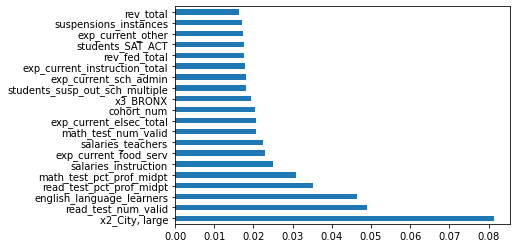

In [192]:
feat_importances = pd.Series(rfc.feature_importances_, index = rfc_columns)
feat_importances.nlargest(20).plot(kind='barh')

### Model reiteration - parameter tuning

Don't set anything to random, choose the ones that you want, don't use trunc norm, set all of them as lists,  then you can use settings like log/auto or floats for percentage of features.

In [193]:
model_params = {
    # number of trees
    'n_estimators': [5,10,20,50,100,200],
    # number of max features
    'max_features': [10,15,20,50,100],
    # max number of levels in each decision tre
    'max_depth': [5,10,15],
    'min_samples_split' : [100,1000]
}

In [194]:
# Instantiate and fit the RandomForestClassifier
rfc=RandomForestClassifier(class_weight='balanced')
rfc = RandomizedSearchCV(rfc,model_params, n_iter=10, cv=3, random_state=1)
rfc.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   param_distributions={'max_depth': [5, 10, 15],
                                        'max_features': [10, 15, 20, 50, 100],
                                        'min_samples_split': [100, 1000],
                                        'n_estimators': [5, 10, 20, 50, 100,
                                                         200]},
                   random_state=1)

In [195]:
print(rfc.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 100, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 1000, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [196]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       211
           1       1.00      1.00      1.00      1756

    accuracy                           1.00      1967
   macro avg       0.99      1.00      0.99      1967
weighted avg       1.00      1.00      1.00      1967



In [197]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.64      0.45      0.53        84
           1       0.94      0.97      0.96       760

    accuracy                           0.92       844
   macro avg       0.79      0.71      0.74       844
weighted avg       0.91      0.92      0.91       844



## XGBoost

# Might Use Later

Change Sci kit learn OHE set sparse to false set handle errors to ignore drop first equals if binary

Change Sci kit learn OHE set sparse to false set handle errors to ignore drop first equals if binary

In [198]:
# print top 5 most frequent values in each grad_rate column
for col in df_school['grad_rate_midpt'].columns:
    print(col, '\n', df_school[col].value_counts(normalize=True).head(), '\n\n')


AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
def target_col (row):
   if row['eri_hispanic   '] == 1 :
      return 'Hispanic'
   if row['eri_afr_amer'] + row['eri_asian'] + row['eri_hawaiian'] + row['eri_nat_amer'] + row['eri_white'] > 1 :
      return 'Two Or More'
   if row['eri_nat_amer'] == 1 :
      return 'A/I AK Native'
   if row['eri_asian'] == 1:
      return 'Asian'
   if row['eri_afr_amer']  == 1:
      return 'Black/AA'
   if row['eri_hawaiian'] == 1:
      return 'Haw/Pac Isl.'
   if row['eri_white'] == 1:
      return 'White'
   return 'Other'


In [ ]:
# Returns the percentage of values in a dataframe that are nulls
def null_cleanup_numeric(col_null):
    return
    # Declare Median
    median = col_null.median()
    # fillna with zeros 
    col_null.update(col_null.fillna(0))
    # convert columns to numeric
    col_null.astype(str).astype(float)
    # Replace zeros with median
    col_null.replace([0], median)
    
   

In [ ]:
df_school[['read_test_num_valid','math_test_num_valid']] = df_school[['read_test_num_valid','math_test_num_valid']].apply(null_cleanup_numeric)

In [ ]:
df_school.info()

In [ ]:
# fillna with zeros so we can convert to numeric
df_school.update(df_school[['math_test_pct_prof_midpt']].fillna(0))
df_school.update(df_school[['read_test_pct_prof_midpt']].fillna(0))

In [ ]:
# convert grad rate columns to numeric
df_school[['math_test_pct_prof_midpt']] = df_school[['math_test_pct_prof_midpt']].astype(str).astype(float)
df_school[['read_test_pct_prof_midpt']] = df_school[['read_test_pct_prof_midpt']].astype(str).astype(float)


In [ ]:
# Replace the two null values with the median of the midpoint columns
math_median = df_school['math_test_pct_prof_midpt'].median()
print(math_median)
read_median = df_school['read_test_pct_prof_midpt'].median()
print(read_median)

In [ ]:
# Replace the two null values with the median of the midpoint columns
df_school.update(df_school[['math_test_pct_prof_midpt']].fillna(math_median))
df_school.update(df_school[['read_test_pct_prof_midpt']].fillna(read_median))

In [ ]:
# Replace zeros with median
df_school['math_test_pct_prof_midpt'] = df_school['math_test_pct_prof_midpt'].replace([0], math_median)
df_school['read_test_pct_prof_midpt'] = df_school['read_test_pct_prof_midpt'].replace([0], read_median)

In [ ]:
# Let's take a look at the summary statistics

print(df_school['math_test_pct_prof_midpt'].describe())
print(df_school['read_test_pct_prof_midpt'].describe())

In [ ]:
df_school.info()

In [ ]:
# Returns the percentage of values in a dataframe that are NaNs
def percent_NaN_df (df,str_name):
    count_NaN = df.isna().sum().sum()
    count_non_NaN = df.count().sum()
    return 'percent of NaNs in '+ str_name +' is '+str(int((count_NaN/(count_NaN + count_non_NaN))*100))+'%'
    

In [ ]:
# Our population columns have the highest proportion of nulls let's take at look
population_cols = ['lea_name','state_name','est_population_total','est_population_5_17_poverty',
                           'est_population_5_17_poverty_pct']

In [ ]:
# Our population columns have the highest proportion of nulls let's take at look
population_cols = ['lea_name','state_name','est_population_total','est_population_5_17_poverty',
                           'est_population_5_17_poverty_pct']